In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import utils
import plotting
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
import vector

In [14]:
#Load your dataset
samples = {
    
    "qcd": [
        "QCD_HT-1000to1200",
        "QCD_HT-1200to1500",
        "QCD_HT-1500to2000",
        "QCD_HT-2000",
        "QCD_HT-200to400",
        "QCD_HT-400to600",
        "QCD_HT-600to800",
        "QCD_HT-800to1000",
    ],
    "ttbar": [
        "TTto4Q",
        "TTtoLNu2Q",
        
    ],  
    "hh4b": [
        "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
    ],
}

year = "2022EE"#
dir_name = "24Jan18_v12"
path_to_dir = f"/eos/uscms/store/user/dprim7/bbbb/skimmer/{dir_name}/"
dirs = {path_to_dir: samples}

filters = [
    [
        ("('ak8FatJetPt', '0')", ">=", 300),
        ("('ak8FatJetPt', '1')", ">=", 300),
        ("('ak8FatJetMsd', '0')", ">=", 50),
        ("('ak8FatJetPNetMass', '1')", ">=", 50),
        ("('ak8FatJetPNetXbb', '0')", ">=", 0.8),  
        
    ]
]

# columns to load                                                                                                                                                                                                                                     
# the parquet files are too big so we can only load a few columns at a time without consumming much memory
load_columns = [
    ("weight", 1),
	("ak8FatJetMsd", 2),
    ("ak8FatJetPNetMass", 2),
	("ak8FatJetPNetXbb", 2),                                                                                                                                                                                                                     
]
# reformat into ("column name", "idx") format for reading multiindex columns                                                                                                                                                                          
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")


events_dict = {}
for input_dir, samples in dirs.items():
   
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters),
    }


print("Keys:")
print(events_dict.keys())
samples_loaded = list(events_dict.keys())
#print(samples_loaded)
keys_loaded = list(events_dict[samples_loaded[0]].keys())

#print(events_dict['qcd'])
#This section prints all keys for inspection
#print(f"Keys in events_dict")
#for i in keys_loaded:
#    print(i)



Loading QCD_HT-1000to1200
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/QCD_HT-1000to1200/parquet
Loading QCD_HT-1200to1500
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/QCD_HT-1200to1500/parquet
Loading QCD_HT-1500to2000
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/QCD_HT-1500to2000/parquet
Loading QCD_HT-2000
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/QCD_HT-2000/parquet


Loading QCD_HT-200to400
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/QCD_HT-200to400/parquet
Loading QCD_HT-600to800
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/QCD_HT-600to800/parquet
Loading QCD_HT-800to1000
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/QCD_HT-800to1000/parquet
Loading TTto4Q
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/TTto4Q/parquet
Loading TTtoLNu2Q
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/TTtoLNu2Q/parquet
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
/eos/uscms/store/user/dprim7/bbbb/skimmer/24Jan18_v12//2022EE/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV/parquet
Keys:
dict_keys(['qcd', 'ttbar', 'hh4b'])
Keys in events_dict
('ak4JetEta', 0)
('ak4JetEta', 1)
('ak4JetEta', 2)
('ak4JetEta', 3)
('ak4JetEta', 4)
('ak4JetEta', 5)
('ak4JetPhi', 0)
('ak4JetPhi', 1)
('ak4JetPhi', 2)
('ak4JetPhi', 3)
('ak4JetPhi', 4)
('ak4JetPhi', 5)
('ak4JetMass', 0)
('ak4J

In [3]:
#Define 4-vector objects
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [4]:
#DEFINE FEATURES & TARGET


events = pd.concat([events_dict["hh4b"], events_dict["qcd"], events_dict["ttbar"]], keys=['hh4b','qcd', 'ttbar'])

#for i,_ in events.columns:
#    print(i)

events['target'] = 0  # Default to 0 (background)
events.loc['hh4b', 'target'] = 1  # Set to 1 for 'hh4b' samples (signal)


# fatjets sorted by xbb
fatjets = make_vector(events, "ak8FatJet")

# H1 candidate
h1 = fatjets[:, 0]
# H2 candidate
h2 = fatjets[:, 1]
# dihiggs candidate object
hh = h1 + h2

#define the dataframe with included features

df = pd.DataFrame({
    'HHlogPt' : np.log(hh.pt),  
    'HHeta' : hh.eta,
    'HHmass' : hh.mass,
    'MET' :  events.MET_pt[0],  
    'H1T32' : events.ak8FatJetTau3OverTau2[0],
    'H2T32' : events.ak8FatJetTau3OverTau2[1],
    'H1Msd' : events.ak8FatJetMsd[0],
    'H1logPt' : np.log(h1.pt),
    'H1eta' : h1.eta,
    'H1Xbb' : events.ak8FatJetPNetXbb[0],
    # Jet1 QCD b score
    # Jet 1 QCDbb score
    # Jet 1 QCDothers score
    'H2logPt' : np.log(h2.pt),
    'H1Pt_HHmass' : h1.pt/hh.mass,
    'H2Pt_HHmass' : h2.pt/hh.mass,
    'H1Pt/H2Pt' : h1.pt/h2.pt,
    # --- additional features to consider? -----
    # delta R 
    # H2Msd
    # number of fatjets in the event
    # others?
})
print(df.shape)

df.replace(np.inf, 10000, inplace=True)
df.replace(-np.inf, 10000, inplace=True)



/tmp/ipykernel_4293/4280353306.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc['hh4b', 'target'] = 1  # Set to 1 for 'hh4b' samples (signal)


(762373, 14)


In [5]:
#Plot Input Variable Distributions

num_columns = len(df.columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(10, 4 * num_columns))

for i, col in enumerate(df.columns):
    axes[i].hist(df[col].dropna(), bins=50, color='blue', alpha=0.7)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Events')

plt.tight_layout()
plt.show()

In [6]:
#LOAD FEATURES INTO PD DF

features = df

#Define target
target = events['target']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [7]:

# Initialize the BDT model
bdt_model = XGBClassifier(
    n_estimators= 196,
    max_depth= 17,
    learning_rate=0.1,
    subsample=0.5,
    random_state=42
)

# Train the model 
bdt_model.fit(X_train, y_train)

# Save the model
model_file = 'boostedBDT.json'
bdt_model.save_model(model_file)

/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

In [8]:
'''
#Load alternate model here

# Create an XGBClassifier instance
bdt_model = xgb.XGBClassifier()

# Load the model from a JSON file
bdt_model.load_model('alt_model.json')
'''

# Make predictions
predictions = bdt_model.predict(X_test)
probabilities = bdt_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)



/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

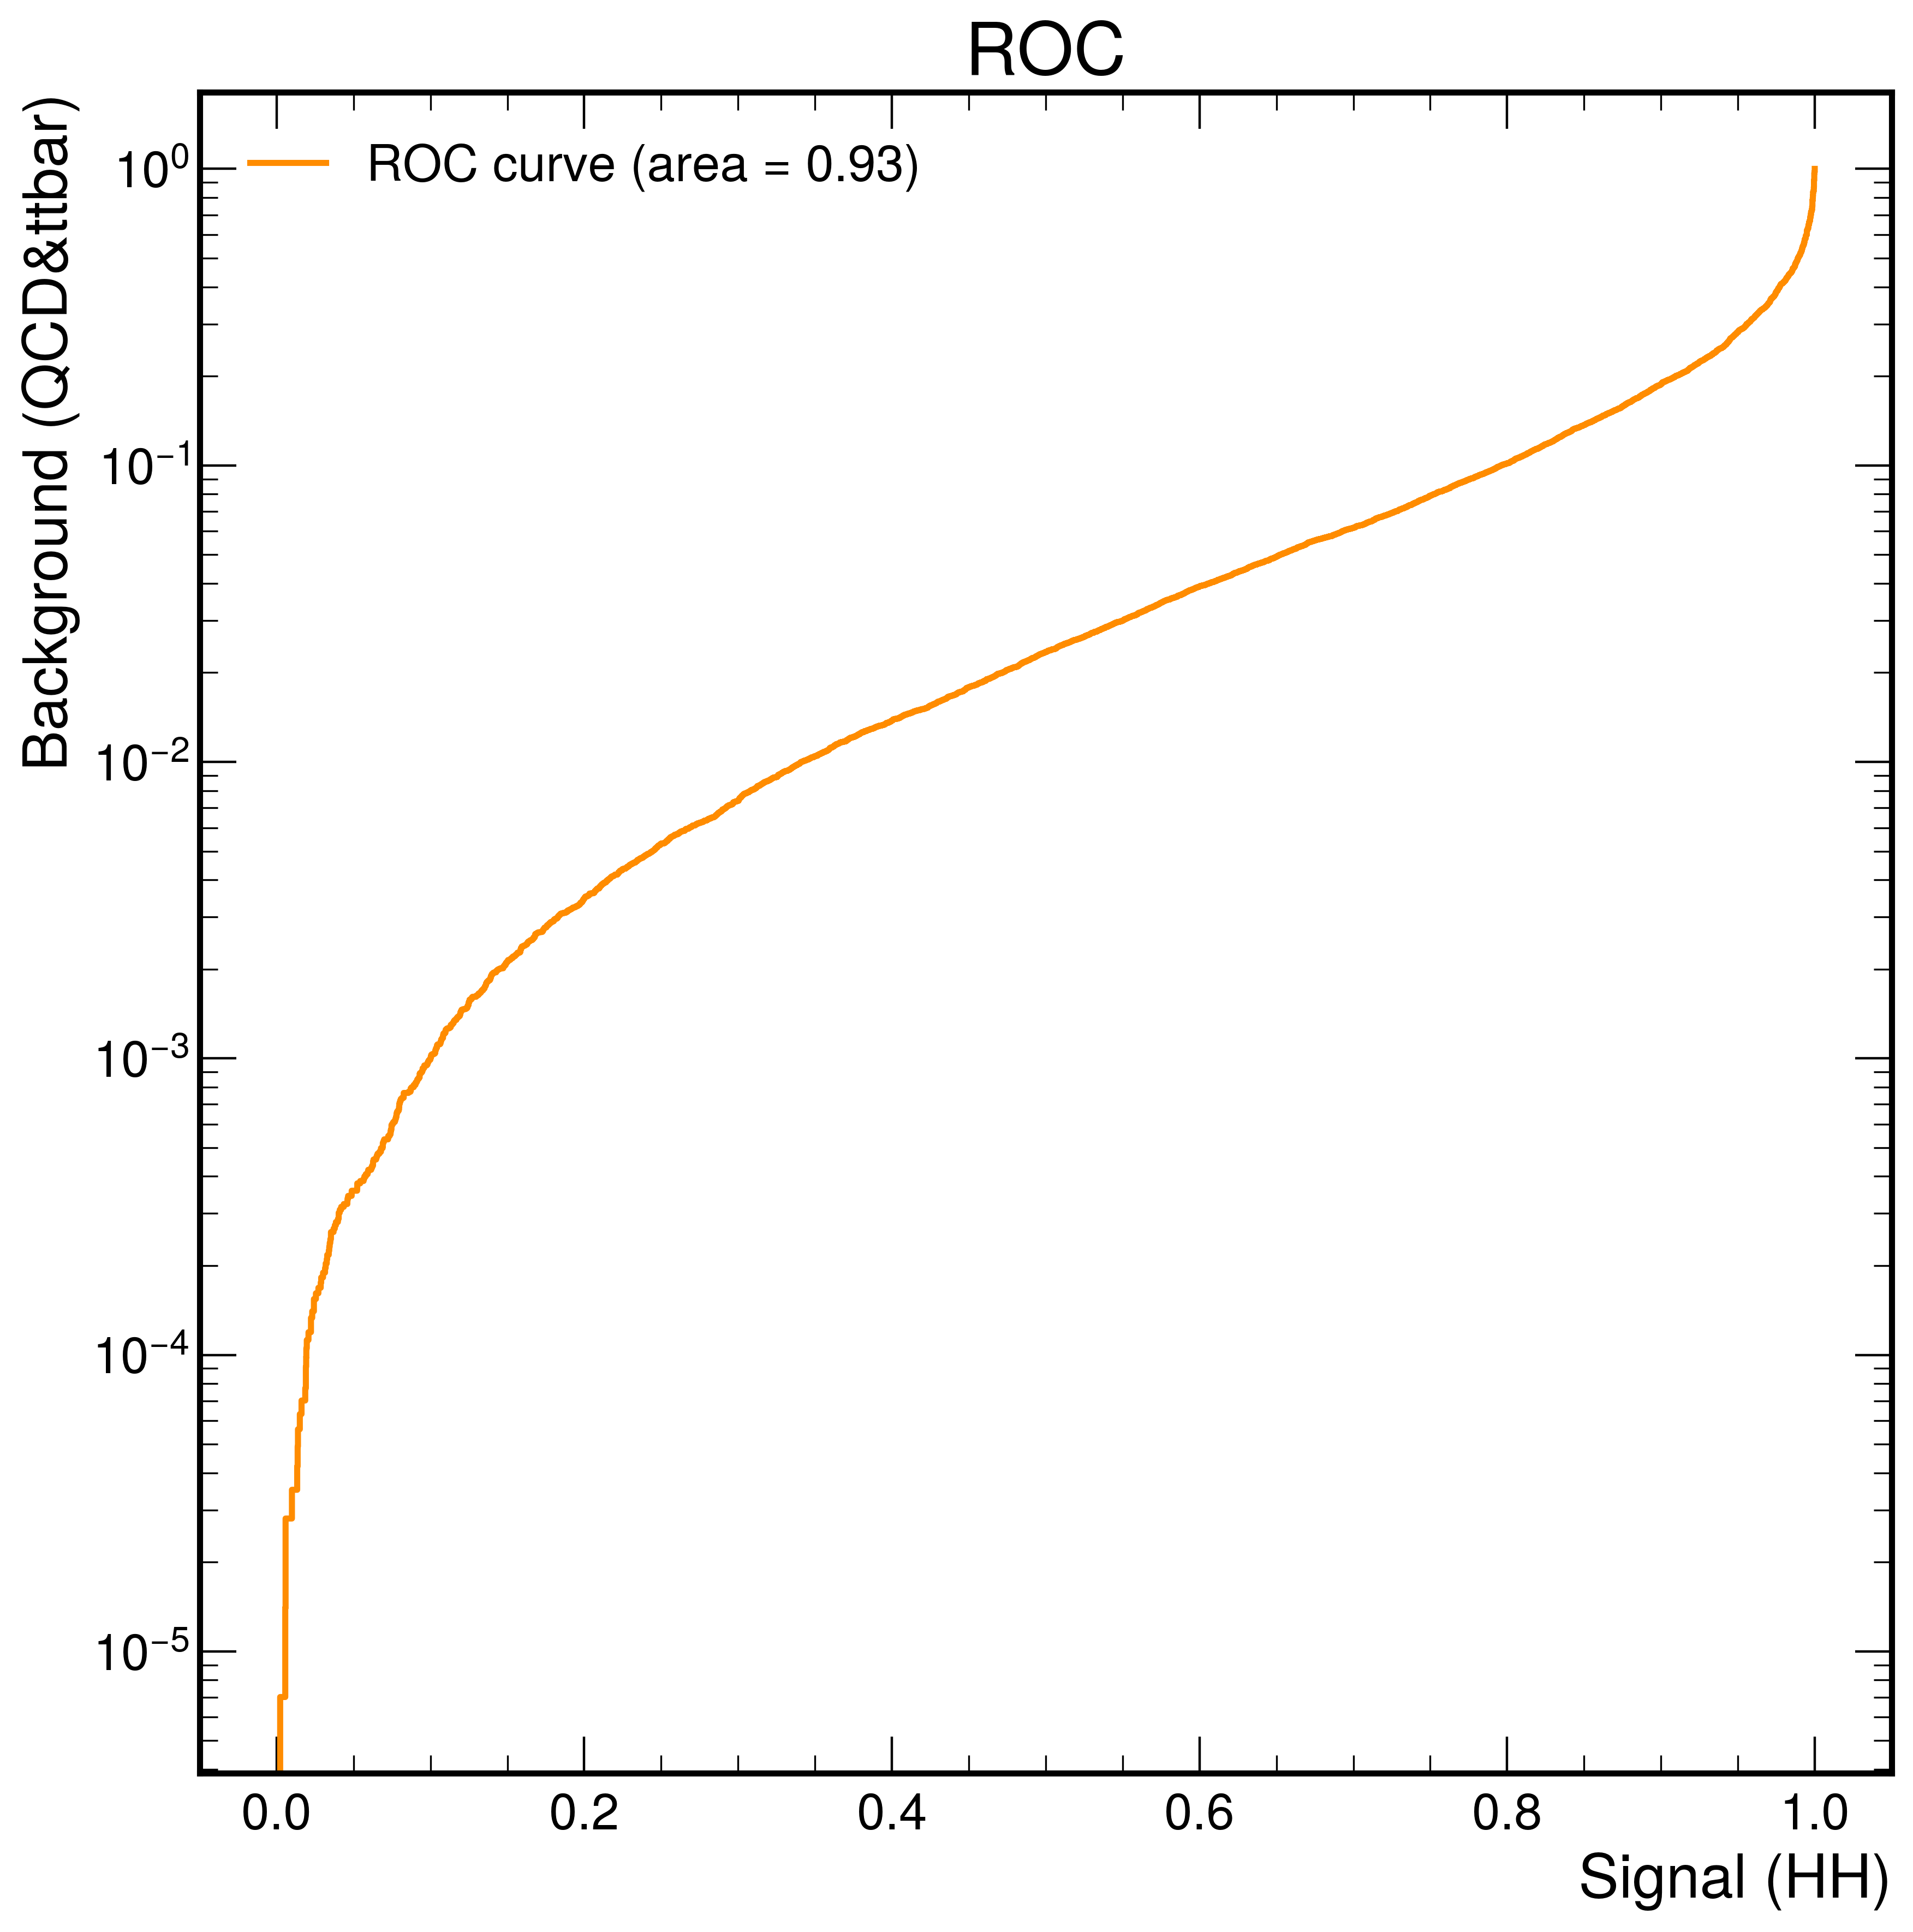

In [9]:
#Plots

y_scores = bdt_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

#histogram for y scores signal & background 
#rank by importance

#number of b-jets that can be identified in resolved
#another feather cos(theta_star)

#Plottting
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('Signal (HH)')
plt.ylabel('Background (QCD&ttbar)')
plt.title('ROC')
plt.legend(loc="upper left")
plt.yscale('log')
plt.savefig('plots/ROC_BDT.png')
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
import numpy as np

# Load data
iris = load_iris()
X, y = iris.data, iris.target

# Define the model
model = RandomForestClassifier()

# Define the hyperparameters and their ranges
search_space = {
    'n_estimators': (10, 200),  # Integer range
    'max_depth': (5, 50)        # Integer range
}

# Set up Bayesian optimization
bayes_search = BayesSearchCV(model, search_space, n_iter=32, scoring='accuracy', cv=5, n_jobs=-1, random_state=0)

# Perform the Bayesian optimization
bayes_search.fit(X, y)

# Best parameters
print("Best parameters:", bayes_search.best_params_)


Best parameters: OrderedDict([('max_depth', 12), ('n_estimators', 159)])


In [11]:
#determine importance of the features

importances = bdt_model.feature_importances_

feature_names = df.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature in feature_importance:
    print(f"{feature[0]}: {feature[1]:.3f}")


HHmass: 0.191
H1Msd: 0.151
H1Xbb: 0.107
H2Pt_HHmass: 0.052
H1eta: 0.052
H1Pt_HHmass: 0.051
HHlogPt: 0.051
H1T32: 0.051
H1logPt: 0.050
H2T32: 0.050
H1Pt/H2Pt: 0.049
MET: 0.049
H2logPt: 0.048
HHeta: 0.048


In [12]:
hh4b_scores = bdt_model.predict_proba(X_test.loc['hh4b'])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc['qcd'])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc['ttbar'])[:, 1]

/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

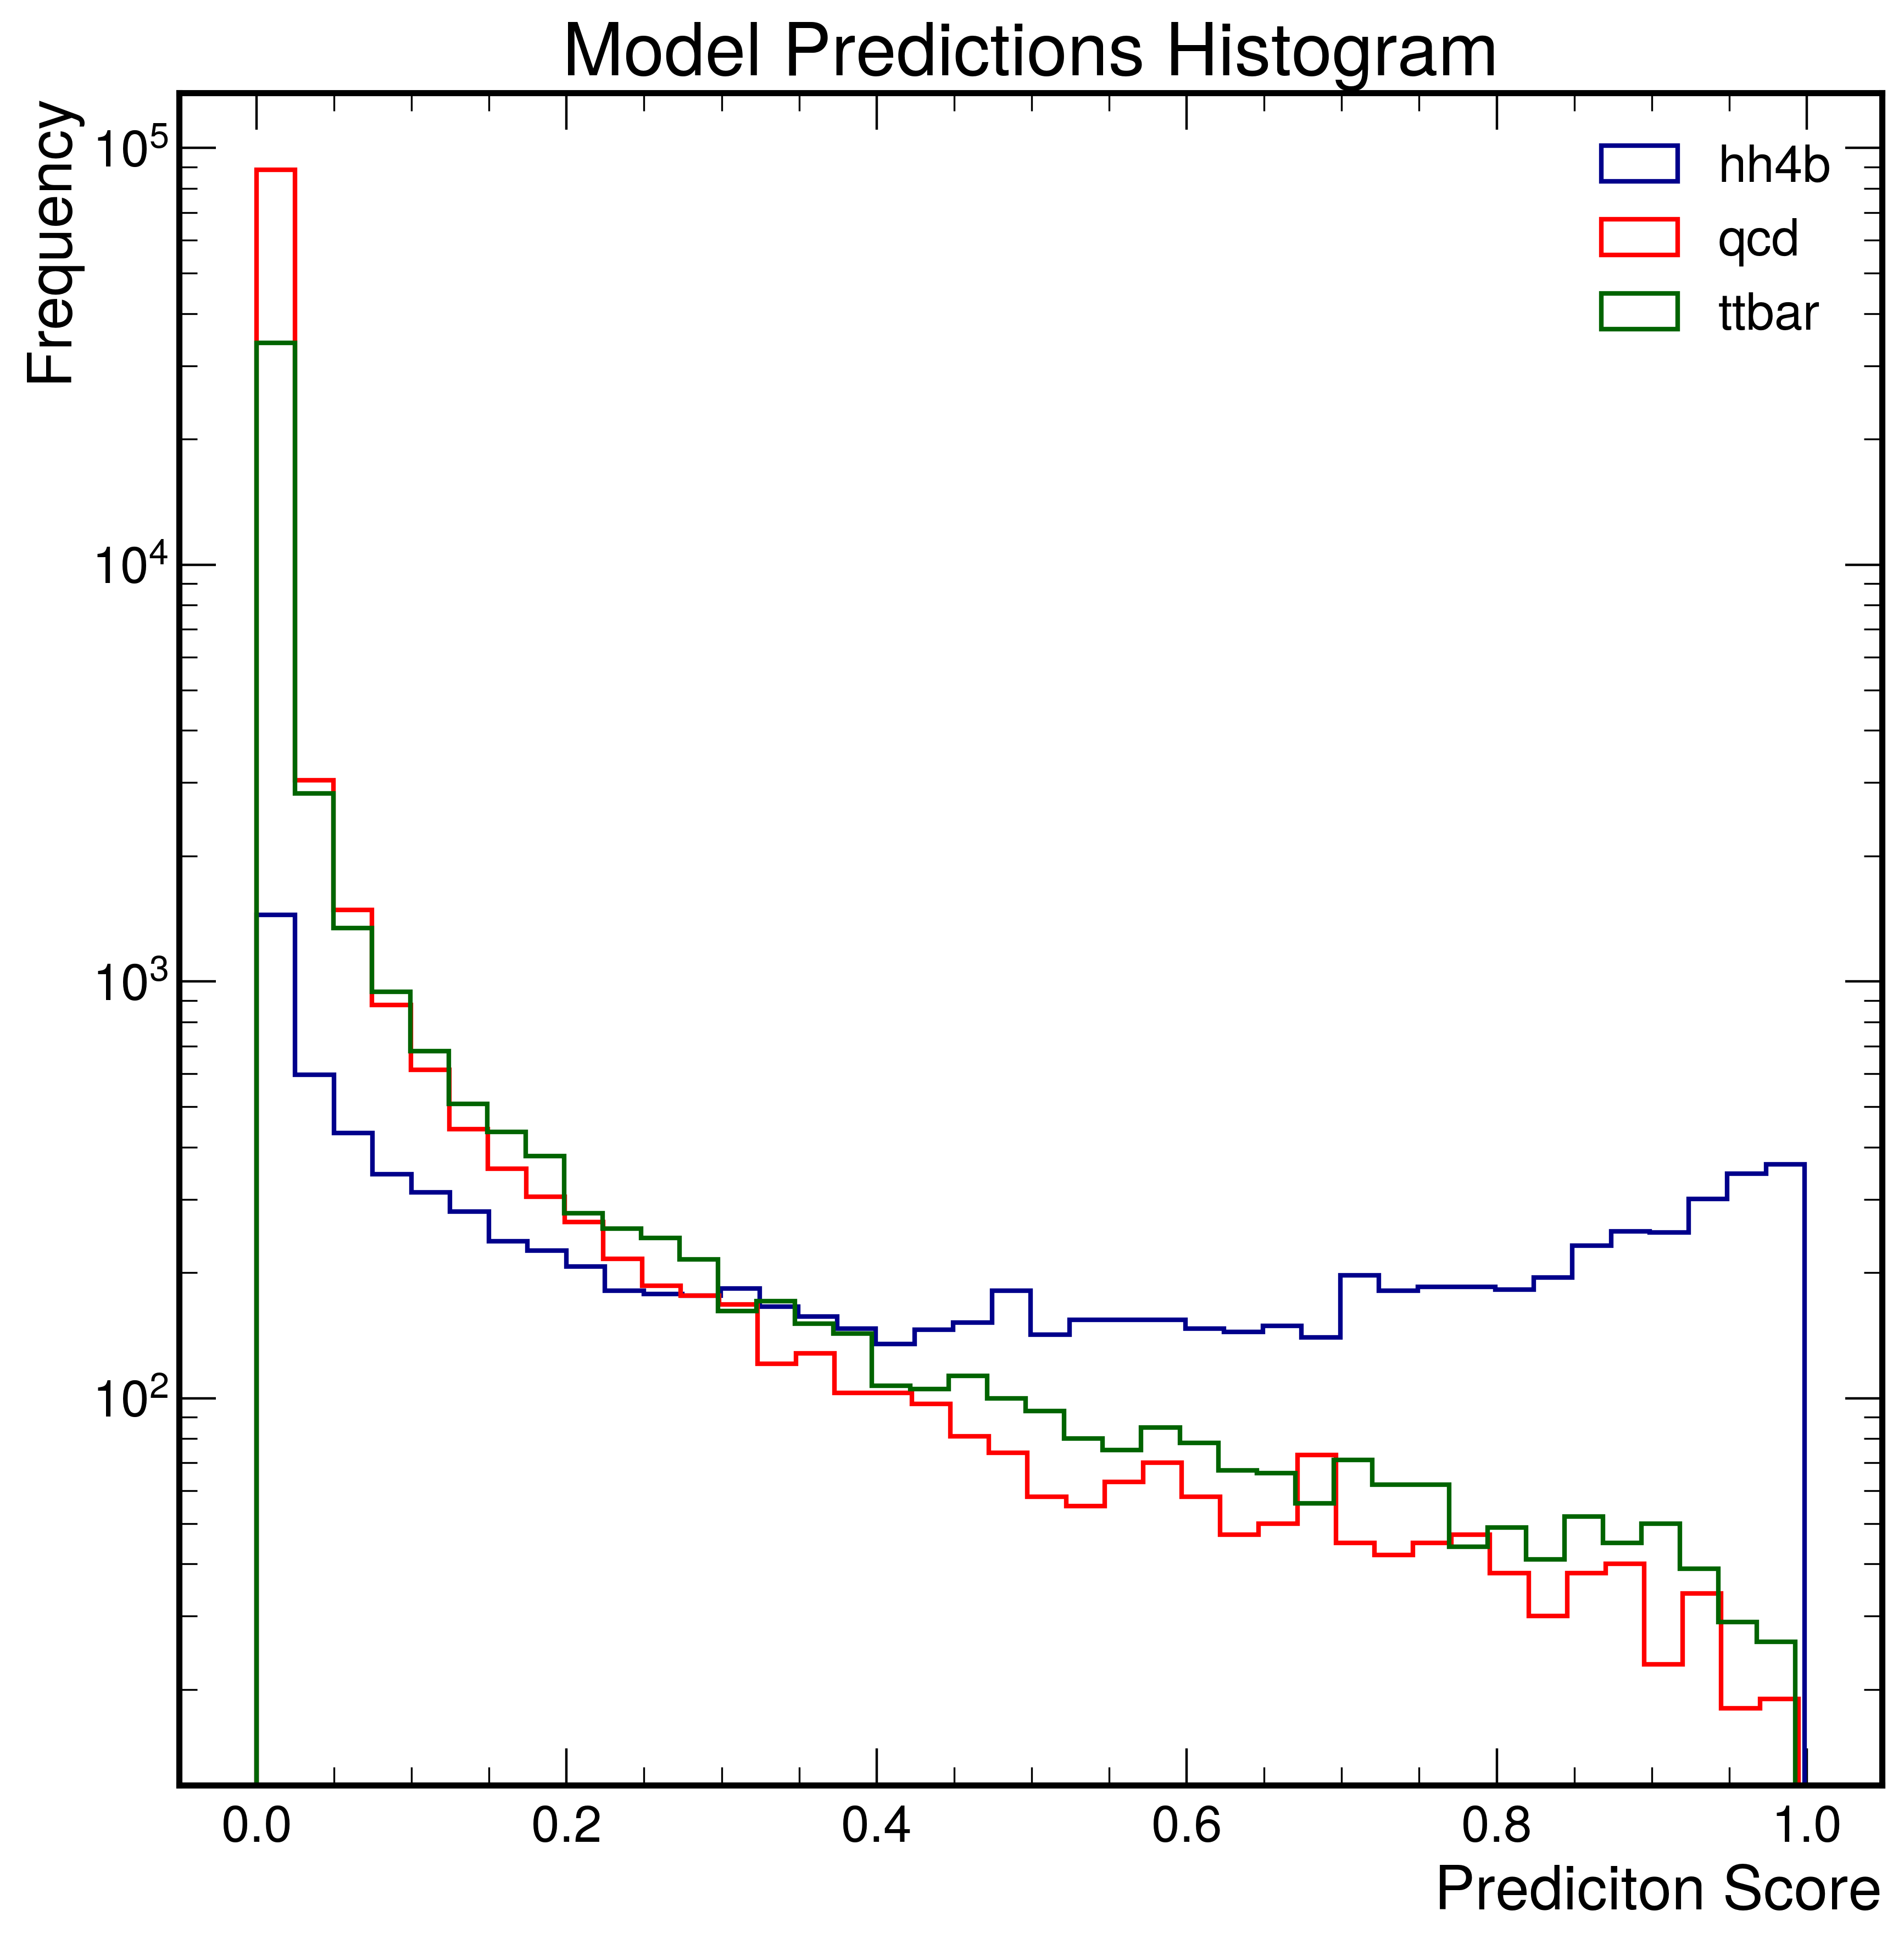

In [13]:
plt.figure()
plt.hist(hh4b_scores, bins=40, histtype='step', linewidth=1.5, color='darkblue')
plt.hist(qcd_scores, bins=40, histtype='step', linewidth=1.5, color='red')
plt.hist(ttbar_scores, bins=40, histtype='step', linewidth=1.5, color='darkgreen')
plt.legend(['hh4b', 'qcd', 'ttbar'])
plt.ylabel('Frequency')
plt.xlabel('Prediciton Score')
plt.title('Model Predictions Histogram')
plt.yscale('log')
plt.show()
